[*********************100%%**********************]  1 of 1 completed
(1111, 1)
Epoch 1/100
33/33 [==============================] - 6s 47ms/step - loss: 0.0365
Epoch 2/100
33/33 [==============================] - 2s 47ms/step - loss: 0.0103
Epoch 3/100
33/33 [==============================] - 2s 48ms/step - loss: 0.0098
Epoch 4/100
33/33 [==============================] - 2s 47ms/step - loss: 0.0082
Epoch 5/100
33/33 [==============================] - 2s 47ms/step - loss: 0.0079
Epoch 6/100
33/33 [==============================] - 2s 47ms/step - loss: 0.0071
Epoch 7/100
33/33 [==============================] - 2s 47ms/step - loss: 0.0071
Epoch 8/100
33/33 [==============================] - 2s 47ms/step - loss: 0.0065
Epoch 9/100
33/33 [==============================] - 2s 49ms/step - loss: 0.0065
Epoch 10/100
33/33 [==============================] - 2s 47ms/step - loss: 0.0062
Epoch 11/100
33/33 [==============================] - 2s 47ms/step - loss: 0.0068
Epoch 12/100
33/33 [========

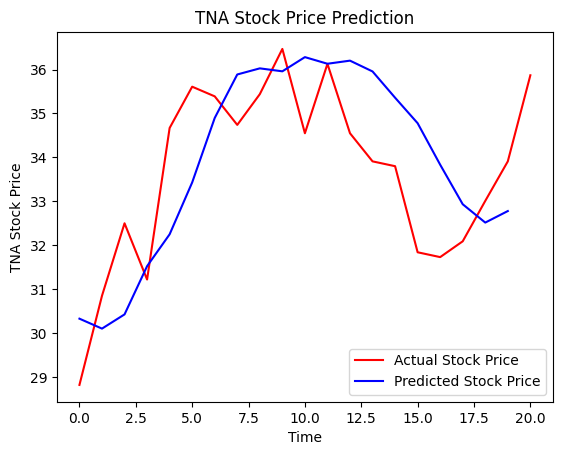

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import yfinance
from sklearn.preprocessing import MinMaxScaler


START = "2019-01-01"
END = "2023-06-01"

def load_data(stock):
    data = yfinance.download(stock, START, END)
    data.reset_index(inplace=True)
    return data

stock = "TNA"

# Retrieving only the open stock price column
dataset_train = load_data(stock)
training_set = dataset_train.iloc[:, 1:2].values
print(training_set.shape)

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0,1))
scaled_training_set = scaler.fit_transform(training_set)

# Creating x_train and y_train data structures
X_train = []
y_train = []
for i in range(60,1111):
    X_train.append(scaled_training_set[i-60:i, 0])
    y_train.append(scaled_training_set[i,0])
X_train = np.array(X_train)
y_train = np.array(y_train)

# Reshape the data
X_train = np.reshape(X_train,(X_train.shape[0], X_train.shape[1],1))

#Building the model by adding layers to LSTM
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

regressor = Sequential()
regressor.add(LSTM(units= 50, return_sequences=True, input_shape= (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units= 50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units= 50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units= 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

#Fitting the model
regressor.compile(optimizer= 'adam', loss= 'mean_squared_error')
regressor.fit(X_train, y_train, epochs=100, batch_size=32)

# Extracting the actual stock prices
CURRENT_START = '2023-06-01'
CURRENT_END = '2023-07-01'

def load_new_data(stock):
    data = yfinance.download(stock, CURRENT_START, CURRENT_END)
    data.reset_index(inplace=True)
    return data

dataset_test = load_new_data(stock)
actual_stock_price = dataset_test.iloc[:, 1:2].values

# Preparing the input for the model
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis=0)
inputs = dataset_total[len(dataset_total) - len(dataset_test)-60:].values

inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

X_test = []
for i in range(60,80):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0], X_test.shape[1], 1))

# Predicting the values for June 2023
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

# Plotting the results
plt.plot(actual_stock_price, color='red', label = 'Actual Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('TNA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TNA Stock Price')
plt.legend()

